# Real Datasets

experiments on various real-world datasets with different characteristics


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from src.experiments import run_exact_proj_svgp
from src.config import TrainCfg
from src.kernels import SM_kernel


## Daily Min Temperatures


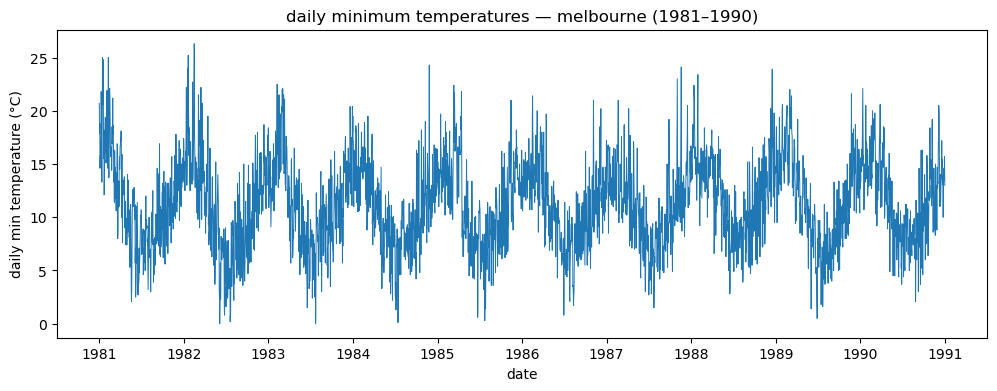

train points: 1200, test points: 300


In [2]:
def load_daily_min_temps():
    """load daily minimum temperatures dataset"""
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
    df = pd.read_csv(url)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=False)
    df = df.dropna(subset=["Date", "Temp"]).sort_values("Date").reset_index(drop=True)
    df = df[np.isfinite(df["Temp"].values)]
    return df

df = load_daily_min_temps()

t0 = df["Date"].min()
x_all = (df["Date"] - t0).dt.days.values.astype(np.float32) / 365.25  # years since start
y_all = df["Temp"].values.astype(np.float32)

# quick sanity plot
plt.figure(figsize=(12, 4))
plt.plot(df["Date"].values, y_all, lw=0.7)
plt.xlabel("date")
plt.ylabel("daily min temperature (°C)")
plt.title("daily minimum temperatures — melbourne (1981–1990)")
plt.show()

TEST_FRAC = 0.2
rng = np.random.default_rng(0)

x_all = x_all[:1500]
y_all = y_all[:1500]

x_tr, x_te, y_tr, y_te = train_test_split(
    x_all, y_all, test_size=TEST_FRAC, random_state=0
)

print(f"train points: {len(x_tr)}, test points: {len(x_te)}")

# grid across the full span for plotting
x_plot = np.linspace(x_all.min(), x_all.max(), 400).astype(np.float32)


running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=36.070972 Delta=inf ||grad||=3.80e+01
noise=0.102 |raw_noise|grad=33.48888397216797
[exact] iter=0100 loss=9.634165 Delta=4.74e-02 ||grad||=8.19e+00
noise=0.367 |raw_noise|grad=7.03594970703125
[exact] iter=0200 loss=5.907763 Delta=1.11e-02 ||grad||=3.58e+00
noise=0.65 |raw_noise|grad=3.311918020248413
[exact] iter=0300 loss=4.602113 Delta=9.54e-06 ||grad||=2.14e+00
noise=0.917 |raw_noise|grad=1.9969103336334229
[exact] iter=0400 loss=3.956363 Delta=1.55e-03 ||grad||=1.46e+00
noise=1.16 |raw_noise|grad=1.3579010963439941
[exact] done | time=16.95s best_loss=3.577900

running spherical GP training | iters=500 lr=0.02 d=400 jitter=0.0001
[proj ] iter=0000 loss=12.494721 Delta=inf ||grad||=3.27e+00
noise=0.1 |raw_noise|grad=0.2644585072994232
[proj ] iter=0100 loss=8.343900 Delta=2.16e-02 ||grad||=1.23e+00
noise=0.117 |raw_noise|grad=0.09847871959209442
[proj ] iter=0200 loss=6.949593 Delta=8.41

/Users/arkin/anaconda3/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


[SVGP] epoch  200/1500: loss=54.601658, Delta_loss=3.31e+00, gradnorm=3.17e+01
[SVGP] epoch  400/1500: loss=31.236088, Delta_loss=2.43e-01, gradnorm=1.87e+01
[SVGP] epoch  600/1500: loss=20.656974, Delta_loss=8.15e-01, gradnorm=1.09e+01
[SVGP] epoch  800/1500: loss=14.011871, Delta_loss=7.99e-02, gradnorm=6.02e+00
[SVGP] epoch 1000/1500: loss=11.170210, Delta_loss=1.24e-01, gradnorm=5.76e+00
[SVGP] epoch 1200/1500: loss=9.550750, Delta_loss=7.64e-01, gradnorm=4.87e+00
[SVGP] epoch 1400/1500: loss=7.095627, Delta_loss=5.63e-01, gradnorm=4.11e+00
[SVGP] epoch 1500/1500: loss=6.986457, Delta_loss=3.01e-01, gradnorm=2.59e+00
                   GPyTorch (exact)           GPyTorch (proj)  \
weight         [8.199595, 4.400191]      [6.835595, 4.780823]   
scale      [0.006634032, 2.0113492]  [0.026296586, 1.2218966]   
mean               [0.0, 2.5180063]          [0.0, 1.8113949]   
noise_var                  1.383002                  0.136244   

                  GPyTorch (SVGP)  
weight   

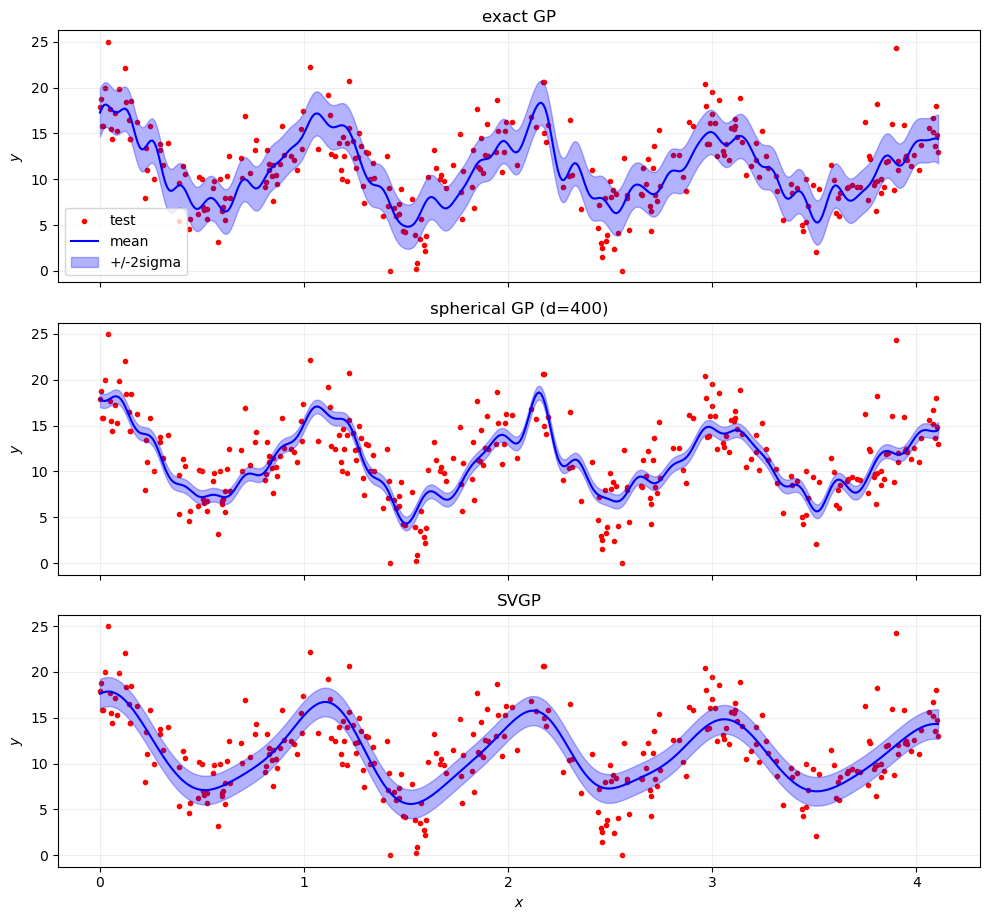

In [3]:
torch.manual_seed(0)
np.random.seed(0)

x_train_t = torch.tensor(x_tr, dtype=torch.float32).unsqueeze(-1)
y_train_t = torch.tensor(y_tr, dtype=torch.float32)
x_test_t  = torch.tensor(x_te, dtype=torch.float32).unsqueeze(-1)
y_test_t  = torch.tensor(y_te, dtype=torch.float32)

run_exact_proj_svgp(
    x_train_t, y_train_t,
    x_test_t,  y_test_t,
    x_plot=x_plot,
    d_proj=400,
    num_mixtures=2,
    add_svgp=True,
    savepath='../results/daily_min_temps.png'
)


## Power Plant Dataset


In [4]:
# load power plant data
ccpp = fetch_ucirepo(id=294)
X_df = ccpp.data.features.rename(columns={
    "AT": "AT", "V": "V", "AP": "AP", "RH": "RH"
})
y_df = ccpp.data.targets.rename(columns={"PE": "PE"})

X_np = X_df[["AT","V","AP","RH"]].iloc[:1000].to_numpy(dtype=np.float32)
y_np = y_df["PE"].iloc[:1000].to_numpy(dtype=np.float32)

X_tr, X_te, y_tr, y_te = train_test_split(X_np, y_np, test_size=0.2, random_state=0)

x_scaler = StandardScaler().fit(X_tr)
X_tr_s = x_scaler.transform(X_tr).astype(np.float32)
X_te_s = x_scaler.transform(X_te).astype(np.float32)

y_tr_s = y_tr.astype(np.float32)
y_te_s = y_te.astype(np.float32)

# torch tensors
x_train_ccpp = torch.tensor(X_tr_s, dtype=torch.float32)
y_train_ccpp = torch.tensor(y_tr_s, dtype=torch.float32)
x_test_ccpp  = torch.tensor(X_te_s, dtype=torch.float32)
y_test_ccpp  = torch.tensor(y_te_s, dtype=torch.float32)

print(f"train: {len(x_train_ccpp)}, test: {len(x_test_ccpp)}")
print(f"features: {X_df.columns.tolist()}")

# 1D plotting path in 4D space (vary AT, fix V/AP/RH at medians of train set)
medians = np.median(X_tr, axis=0)
at_lin   = np.linspace(X_np[:,0].min(), X_np[:,0].max(), 400).astype(np.float32)
x_plot_ccpp_orig = np.tile(medians[None,:], (len(at_lin),1))
x_plot_ccpp_orig[:,0] = at_lin
x_plot_ccpp = x_scaler.transform(x_plot_ccpp_orig).astype(np.float32)


train: 800, test: 200
features: ['AT', 'V', 'AP', 'RH']


In [5]:
torch.manual_seed(0)
np.random.seed(0)

kernel_exact = SM_kernel(2, 4)
kernel_proj = SM_kernel(2, 4)
kernel_svgp = SM_kernel(2, 4)

run_exact_proj_svgp(
    x_train_ccpp, y_train_ccpp,
    x_test_ccpp,  y_test_ccpp,
    x_plot_ccpp,
    d_proj=200,
    kernel_exact=kernel_exact, 
    kernel_proj=kernel_proj, 
    kernel_svgp=kernel_svgp, 
    add_svgp=True, flag=True
)


TypeError: run_exact_proj_svgp() got multiple values for argument 'd_proj'

## CASP Protein Tertiary Structure


In [ ]:
try:
    df_casp = pd.read_csv('../data/CASP.csv')
    print(f"loaded CASP data: {df_casp.shape}")
    
    y_series = df_casp["RMSD"]
    X_df = df_casp.drop(columns=["RMSD"])
    
    X_df = X_df.select_dtypes(include=[np.number]).copy()  # just numeric columns
    
    # train/test split
    X_train_df, X_test_df, y_train_np, y_test_np = train_test_split(
        X_df.values, y_series.values.astype(np.float32),
        test_size=0.2, random_state=0
    )
    
    # standardise features and (optionally) target
    x_scaler = StandardScaler().fit(X_train_df)
    X_train = x_scaler.transform(X_train_df).astype(np.float32)
    X_test  = x_scaler.transform(X_test_df).astype(np.float32)
    
    y_scaler = StandardScaler().fit(y_train_np.reshape(-1, 1))
    y_train = y_scaler.transform(y_train_np.reshape(-1,1)).astype(np.float32).ravel()
    y_test  = y_scaler.transform(y_test_np.reshape(-1,1)).astype(np.float32).ravel()
    
    # (optional) downsample for the exact GP baseline
    N_exact = min(1000, X_train.shape[0])   # exact GP on 1k; adjust if needed
    idx_exact = np.random.default_rng(0).choice(X_train.shape[0], size=N_exact, replace=False)
    X_train_exact = X_train[idx_exact]
    y_train_exact = y_train[idx_exact]
    
    print(f"using {N_exact} samples for exact GP, full {len(X_train)} for projection GP")
    print(f"features: {X_df.shape[1]}")
    
except FileNotFoundError:
    print("CASP.csv not found in data directory - skipping this dataset")


In [ ]:
# run experiment if CASP data was loaded
if 'df_casp' in locals():
    torch.manual_seed(0)
    np.random.seed(0)
    
    # torch tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_train_exact_t = torch.tensor(X_train_exact, dtype=torch.float32, device=device)
    y_train_exact_t = torch.tensor(y_train_exact, dtype=torch.float32, device=device)
    x_train_full_t  = torch.tensor(X_train,       dtype=torch.float32, device=device)
    y_train_full_t  = torch.tensor(y_train,       dtype=torch.float32, device=device)
    x_test_t        = torch.tensor(X_test,        dtype=torch.float32, device=device)
    y_test_t        = torch.tensor(y_test,        dtype=torch.float32, device=device)
    
    # construct a 1D plotting path through input space
    # sweep along the first PC (in standardised coordinates) keeping others at zero
    pca = PCA(n_components=1, random_state=0).fit(X_train)
    pc1_vec = pca.components_[0].astype(np.float32)              # shape [D]
    t_min, t_max = -3.0, 3.0                                     # span along PC1
    x_plot_param = np.linspace(t_min, t_max, 400).astype(np.float32)
    x_plot_path = np.outer(x_plot_param, pc1_vec)                # [400, D]
    
    D = X_train.shape[1]
    y_std=float(torch.std(y_train_exact_t))
    
    # use RBF + Periodic sum kernel for high-dimensional data
    from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel, AdditiveKernel
    
    def make_rbf_periodic_sum(num_dims, y_std):
        rbf = RBFKernel(ard_num_dims=num_dims)
        per = PeriodicKernel(ard_num_dims=num_dims)
        ksum = AdditiveKernel(rbf, per)
        return ScaleKernel(ksum)  # outputscale
    
    kernel_exact = make_rbf_periodic_sum(D, y_std)
    kernel_proj  = make_rbf_periodic_sum(D, y_std)
    kernel_svgp = make_rbf_periodic_sum(D, y_std)
    
    d_proj = 300
    max_iter = 800
    learning_rate = 0.03
    
    print(f"running on device: {device}")
    
    # note: this would need the exact_vs_spherical function from your original code
    # for now, let's use a simpler version with run_exact_proj_svgp
    print("running simplified experiment (modify as needed for your exact_vs_spherical function)")
    
else:
    print("skipping CASP experiment - no data loaded")


## Sunspots Dataset


In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df = df.dropna()

# y: normalised as in your snippet
y_all = df.iloc[:, 0].to_numpy(dtype=np.float32)
y_all = (y_all - np.mean(y_all)) / np.mean(y_all)

# x: map time to [0, 100] (float32)
t0 = df.index[0]
x_raw = ((df.index - t0).total_seconds().astype('float32') / 86_400.0)  # days since start
x_raw = np.array(x_raw)
x_min, x_max = x_raw.min(), x_raw.max()
x_all = 100.0 * (x_raw - x_min) / (x_max - x_min)  # [0, 100]

rng = np.random.default_rng(0)
perm = rng.permutation(len(x_all))
x_all = x_all[perm]
y_all = y_all[perm]

N = len(df)
n_train = int(0.80 * N)

x_train_np = x_all[:n_train].astype(np.float32)
y_train_np = y_all[:n_train].astype(np.float32)
x_test_np  = x_all[n_train:].astype(np.float32)
y_test_np  = y_all[n_train:].astype(np.float32)

# torch tensors (column vectors for GPs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = torch.from_numpy(x_train_np).unsqueeze(-1).to(device)  # [N_train, 1]
y_train = torch.from_numpy(y_train_np).unsqueeze(-1).view(-1).to(device)  # [N_train, 1]
x_test  = torch.from_numpy(x_test_np).unsqueeze(-1).to(device)   # [N_test, 1]
y_test  = torch.from_numpy(y_test_np).unsqueeze(-1).view(-1).to(device)   # [N_test, 1]

# a dense grid covering the whole range for smooth plots
x_plot = np.linspace(x_all.min(), x_all.max(), 1000).astype(np.float32)

print(f"train: {len(x_train)}, test: {len(x_test)}")


In [ ]:
torch.manual_seed(0)
np.random.seed(0)

d_proj = 300          
num_mixtures = 2      # works well on sunspot-like quasi-periodic series
kernel_exact = kernel_proj = kernel_svgp = None

run_exact_proj_svgp(
    x_train, y_train, x_test, y_test,
    x_plot=x_plot,
    d_proj=d_proj,
    num_mixtures=num_mixtures,
    cfg=TrainCfg(verbose=True, use_lbfgs=False, max_iter=800, loss_tol=1e-6,
    grad_tol=1e-4, patience=60, lr=0.05),
    kernel_exact=kernel_exact,
    kernel_proj=kernel_proj,
    kernel_svgp=kernel_svgp,
    add_svgp=False,
    savepath='../results/sunspots.png'
)
